In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

https://www.kaggle.com/code/vipulgandhi/kmeans-detailed-explanation/notebook

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from nltk.corpus import stopwords
import tensorflow_hub as hub
from sklearn.feature_extraction import text
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading data

In [4]:
df= pd.read_csv("/kaggle/input/brexit/brexit.csv",error_bad_lines=False,usecols =["text"])
df.head()

,text
0,在龙胜！\n
1,@Fenng 大冯啊。你没有觉得我帐号很帅。\n
2,其实我上来一次很不容易，有朋友说对我的ID感兴趣。虽然这是我无法割舍的帐号，但是每个人都是有...
3,还有。为什么我的头像被换成了个鸡蛋。太坏了吧\n
4,Why is always someone trying to crack my passw...


In [5]:
df.duplicated().sum()

2558

In [6]:
df=df.drop_duplicates()

In [7]:
df.duplicated().sum()

0

In [8]:
df.head(10)

,text
0,在龙胜！\n
1,@Fenng 大冯啊。你没有觉得我帐号很帅。\n
2,其实我上来一次很不容易，有朋友说对我的ID感兴趣。虽然这是我无法割舍的帐号，但是每个人都是有...
3,还有。为什么我的头像被换成了个鸡蛋。太坏了吧\n
4,Why is always someone trying to crack my passw...
5,偶也。上来了。\n
6,"RT @lang8: Finally, the access problem has bee..."
7,喂，我不明白啊。因为某些人不干好事，就不让我这个良民上不了twitter和dropbox吗？...
8,很久没上来。看看发生啥事情了。求dropxbox解封啊。。。\n
9,RT @chujiu: 今天一早睁开眼之后，发现三件可怕的事情：电饭煲开着，六点钟天已经亮了...


In [9]:
# shuffle the DataFrame rows
df = df.sample(frac = 1)
df.head(10)

,text
369399,"I've just made a thing, and used it. It was sa..."
356898,RT @vz_wang: Yale announces first college-wide...
95971,Lol https://twitter.com/chelleryn99/status/669...
124931,Leicester have enough to replace Vardy with Mi...
340658,@sueveneer @TheSun Reminds me of front pages a...
171342,@pleep1 http://pbs.twimg.com/tweet_video_thumb...
51236,'Scotland will only make progress if we debate...
53193,David Cameron is plain wrong about Oxford and ...
219173,RT @asianculturevul: Who is going to hear one ...
144094,RT @Queen_UK: British Empire of a hangover. #B...


In [10]:
len(df['text'].unique())

369427

### Dataset details

In [11]:
df.describe()

,text
count,369427
unique,369427
top,"I've just made a thing, and used it. It was sa..."
freq,1


## Data Cleaning Preprocessing

In [12]:
contractions = { 
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he shall / he will",
    "he'll've": "he shall have / he will have",
    "he's": "he has / he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "I'd": "I had / I would",
    "I'd've": "I would have",
    "I'll": "I shall / I will",
    "I'll've": "I shall have / I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it shall have / it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she shall / she will",
    "she'll've": "she shall have / she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they shall / they will",
    "they'll've": "they shall have / they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what'll've": "what shall have / what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who shall / who will",
    "who'll've": "who shall have / who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you shall / you will",
    "you'll've": "you shall have / you will have",
    "you're": "you are",
    "you've": "you have"
}

In [13]:
contractions_re=re.compile('(%s)' % '|'.join(contractions.keys()))

def expand_contractions(text,contractions_dict=contractions):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews

In [14]:
def remove_URL(text):
    text=str(text)
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_mentions(text):
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    return ment.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [15]:

df['clean_text'] = df['text'].apply(lambda x: remove_URL(x))
df['clean_text'] = df['clean_text'].apply(lambda x: expand_contractions(x))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(x))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(x))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_mentions(x))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punct(x))
df['clean_text'] = df['clean_text'].apply(lambda x: x.lower())

In [16]:
df.head()

,text,clean_text
369399,"I've just made a thing, and used it. It was sa...",i have just made a thing and used it it was sa...
356898,RT @vz_wang: Yale announces first college-wide...,rt wang yale announces first collegewide acade...
95971,Lol https://twitter.com/chelleryn99/status/669...,lol \n
124931,Leicester have enough to replace Vardy with Mi...,leicester have enough to replace vardy with mi...
340658,@sueveneer @TheSun Reminds me of front pages a...,reminds me of front pages after murder of re...


In [17]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.remove('not')
stop_words.add('rt')

In [18]:
cleaned = df['clean_text'].tolist()

for i,text in enumerate(cleaned):
    splits = text.split()
    splits = [word for word in splits if word not in stop_words]
    cleaned[i]=' '.join(splits)
    
df['clean_text']=cleaned
    

In [19]:
df.head()

,text,clean_text
369399,"I've just made a thing, and used it. It was sa...",made thing used satisfactory tweetliketomfox
356898,RT @vz_wang: Yale announces first college-wide...,wang yale announces first collegewide academic...
95971,Lol https://twitter.com/chelleryn99/status/669...,lol
124931,Leicester have enough to replace Vardy with Mi...,leicester enough replace vardy milik michy lac...
340658,@sueveneer @TheSun Reminds me of front pages a...,reminds front pages murder reeva steenkamp sex...


In [20]:
df= df.dropna()
df

,text,clean_text
369399,"I've just made a thing, and used it. It was sa...",made thing used satisfactory tweetliketomfox
356898,RT @vz_wang: Yale announces first college-wide...,wang yale announces first collegewide academic...
95971,Lol https://twitter.com/chelleryn99/status/669...,lol
124931,Leicester have enough to replace Vardy with Mi...,leicester enough replace vardy milik michy lac...
340658,@sueveneer @TheSun Reminds me of front pages a...,reminds front pages murder reeva steenkamp sex...
...,...,...
155668,@MarksLarks Don't see how that would be possib...,dont see would possible not sure describe wate...
214225,RT @Historiamagoria: For those wanting to cycl...,wanting cycle aseh2013 racks beside hotel york...
250437,Biggest question from today's 'we got it wrong...,biggest question todays got wrong polling repo...
133718,RT @SoulFeatures: What a line up!! : @cherriv...,line dwight tickets


In [21]:
df = df.drop_duplicates('clean_text')
df

,text,clean_text
369399,"I've just made a thing, and used it. It was sa...",made thing used satisfactory tweetliketomfox
356898,RT @vz_wang: Yale announces first college-wide...,wang yale announces first collegewide academic...
95971,Lol https://twitter.com/chelleryn99/status/669...,lol
124931,Leicester have enough to replace Vardy with Mi...,leicester enough replace vardy milik michy lac...
340658,@sueveneer @TheSun Reminds me of front pages a...,reminds front pages murder reeva steenkamp sex...
...,...,...
155668,@MarksLarks Don't see how that would be possib...,dont see would possible not sure describe wate...
214225,RT @Historiamagoria: For those wanting to cycl...,wanting cycle aseh2013 racks beside hotel york...
250437,Biggest question from today's 'we got it wrong...,biggest question todays got wrong polling repo...
133718,RT @SoulFeatures: What a line up!! : @cherriv...,line dwight tickets


In [22]:
corpus= df['clean_text'].values
corpus

array(['made thing used satisfactory tweetliketomfox',
       'wang yale announces first collegewide academic extension creditfail conversion light recent campus tensions …',
       'lol', ...,
       'biggest question todays got wrong polling report consistently wrong opinion polls affect voters voted',
       'line dwight tickets',
       'simpson93 well give credit punching weight heavyhitter'],
      dtype=object)

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
vectorizer = CountVectorizer()

In [25]:
X = vectorizer.fit_transform(corpus)

In [26]:
X

<349447x163504 sparse matrix of type '<class 'numpy.int64'>'
	with 2802011 stored elements in Compressed Sparse Row format>

In [27]:
vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., '⁰media', '⁰san', '₀₀'], dtype=object)

In [28]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X = vectorizer2.fit_transform(corpus)
X

<349447x1692791 sparse matrix of type '<class 'numpy.int64'>'
	with 2501713 stored elements in Compressed Sparse Row format>

In [29]:
vectorizer2.get_feature_names_out()

array(['00 04', '00 10', '00 1st', ..., '⁰as twist', '⁰media succumbs',
       '⁰san francisco'], dtype=object)

In [30]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [31]:
vectorizer3 = CountVectorizer(analyzer='word',stop_words =list(stop_words), tokenizer = tokenize,max_features=1000, ngram_range=(2, 2))
X = vectorizer3.fit_transform(corpus)
X

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)


<349447x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 142775 stored elements in Compressed Sparse Row format>

In [32]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'Inertia')

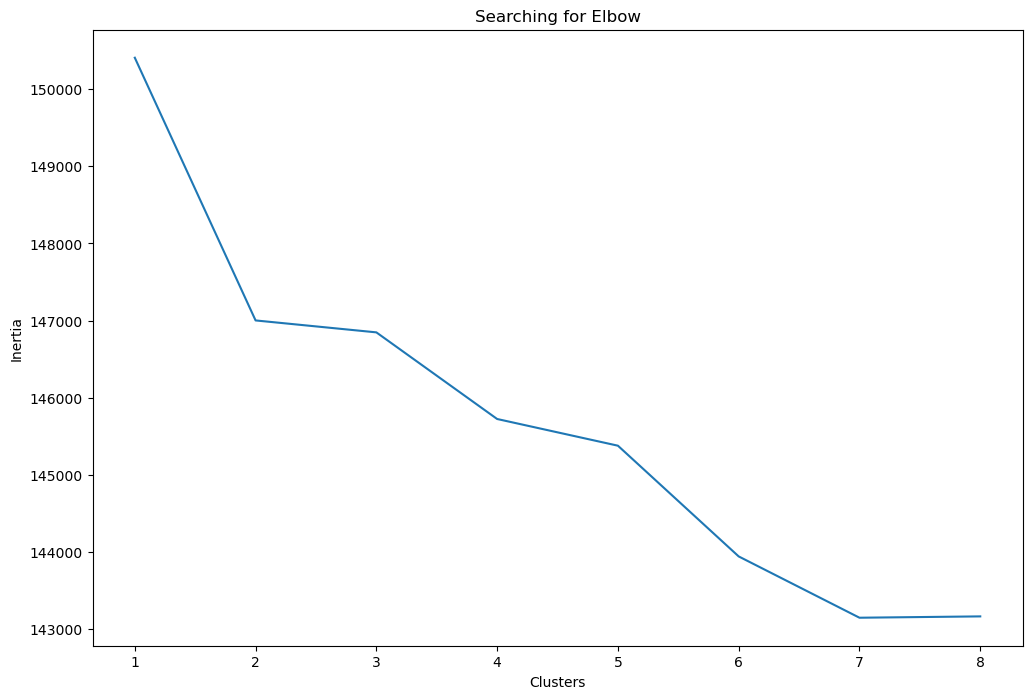

In [33]:
clusters = []

for i in range(1, 9):
    km = KMeans(n_clusters=i).fit(X)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 9)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')


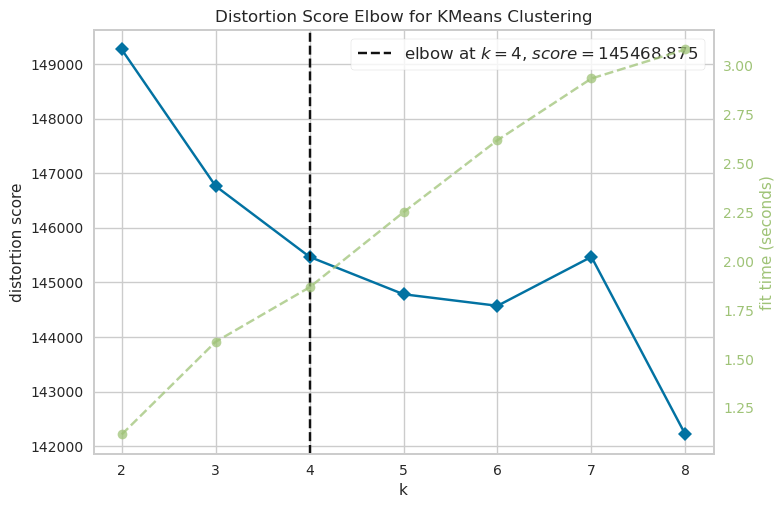

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,9))
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [35]:
from sklearn.metrics import silhouette_score
silhouette_scores = [] 

for n_cluster in range(2, 9):
    silhouette_scores.append( 
        silhouette_score(X, KMeans(n_clusters = n_cluster).fit_predict(X))) 
    
silhouette_scores

[0.8466453884397902,
 0.5651086456496287,
 0.6074943609870539,
 0.5673165929945608,
 0.5506244147158778,
 0.5582372060963204,
 0.5530646961776887]

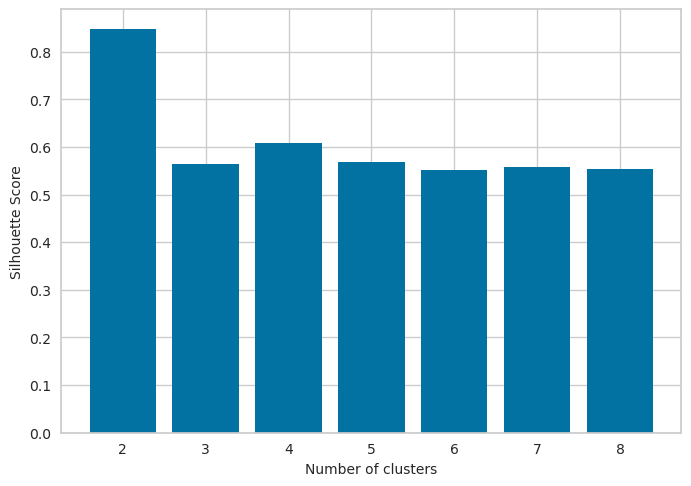

In [36]:
k = [2,3,4,5,6,7,8]
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

In [37]:
max_value = max(silhouette_scores)
max_index = silhouette_scores.index(max_value)
print(max_index)

0


In [38]:
number_of_cluster=max_index+2
number_of_cluster

2

In [39]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(KMeans(n_clusters=number_of_cluster), {
#     'n_clusters': [2,3,4],
    'max_iter': [300,400,500],
    'init': ['random','k-means++'],
    'algorithm': ['auto', 'full','elkan'],
    'tol':[0.0001,0.00001]
}, return_train_score=False)

In [40]:
clf.fit(X)
# clf.cv_results_

GridSearchCV(estimator=KMeans(n_clusters=2),
             param_grid={'algorithm': ['auto', 'full', 'elkan'],
                         'init': ['random', 'k-means++'],
                         'max_iter': [300, 400, 500], 'tol': [0.0001, 1e-05]})

In [41]:
df2= pd.DataFrame(clf.cv_results_)
# df2

In [42]:
df2[['param_max_iter','param_init','param_tol','param_algorithm','mean_test_score']]

,param_max_iter,param_init,param_tol,param_algorithm,mean_test_score
0,300,random,0.0001,auto,-29711.933304
1,300,random,0.00001,auto,-29566.911455
2,400,random,0.0001,auto,-29874.047300
3,400,random,0.00001,auto,-29749.658469
4,500,random,0.0001,auto,-29901.865802
5,500,random,0.00001,auto,-29572.563152
6,300,k-means++,0.0001,auto,-29457.586822
7,300,k-means++,0.00001,auto,-29400.830082
8,400,k-means++,0.0001,auto,-29511.741101
9,400,k-means++,0.00001,auto,-29564.445736


In [43]:
clf.best_params_

{'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 300, 'tol': 1e-05}

In [44]:
kmeans = KMeans(n_clusters=number_of_cluster,init=clf.best_params_['init'], max_iter=clf.best_params_['max_iter'], tol=clf.best_params_['tol'],algorithm=clf.best_params_['algorithm'])

In [45]:
kmeans.fit(X)

KMeans(n_clusters=2, tol=1e-05)

In [46]:
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [47]:
kmeans.predict(X[2])

array([1], dtype=int32)

In [48]:
y_kmeans =  kmeans.fit_predict(X)
df['K_Means_Cluster']  = y_kmeans

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
#word cloud
def word_cloud(pred_df,label):
    wc = ' '.join([text for text in pred_df['clean_text'][pred_df['K_Means_Cluster'] == label]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(wc)
    fig7 = plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

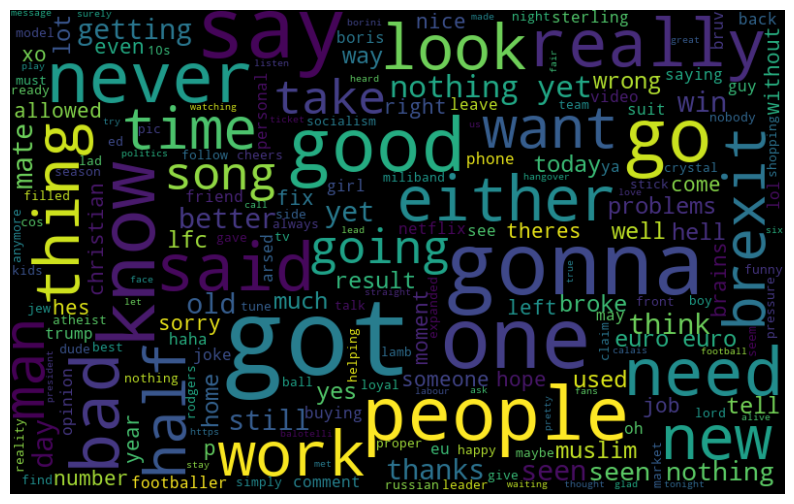

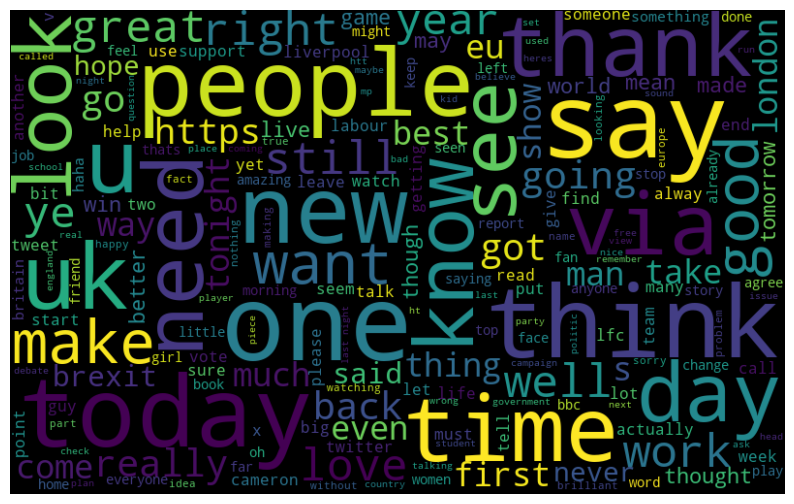

In [50]:
for i in range (0,number_of_cluster):
    word_cloud(df,i)

https://www.kaggle.com/code/jhe2918/clustering-evaluation

In [51]:
from sklearn import metrics

In [52]:
kmeans_ch = metrics.calinski_harabasz_score(X.toarray(), y_kmeans )
kmeans_ch

8093.347139051369

In [53]:
kmeans_db = metrics.davies_bouldin_score(X.toarray(), y_kmeans )
kmeans_db

0.31679653559754095

In [54]:

kmeans_silhouette = metrics.silhouette_score(X, y_kmeans , metric='euclidean')
kmeans_silhouette

0.8466453884397902

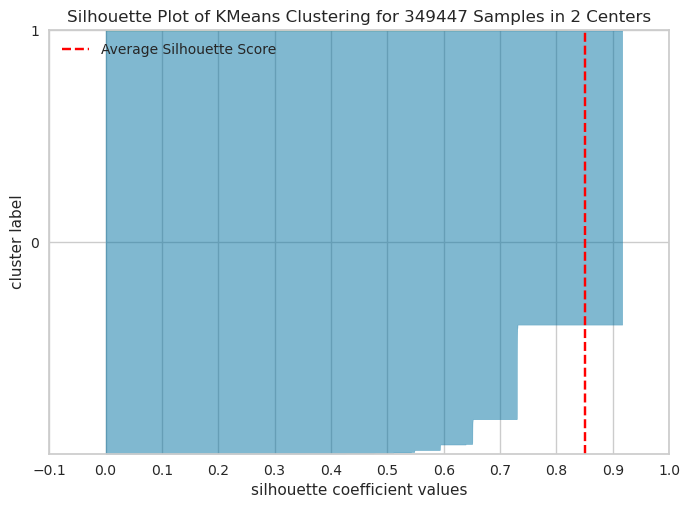

0.8513162464489368


In [55]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer 
# Instantiate the clustering model and visualizer
km = KMeans(n_clusters=number_of_cluster,init=clf.best_params_['init'], max_iter=clf.best_params_['max_iter'], tol=clf.best_params_['tol'],algorithm=clf.best_params_['algorithm'])
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
print(visualizer.silhouette_score_)